## AutoEncoder: Comparative Analysis

In [50]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb 

### CNN AutoEncoder

#### `1. Data Loading and Preprocessing`

In [3]:
path_to_fashion_mnist = "../../data/external/fashion_mnist/"

# split train csv and move 10k rows to val csv
train_csv = pd.read_csv(path_to_fashion_mnist + "fashion_mnist_train.csv")
val_csv = train_csv.sample(n=10000)
train_csv = train_csv.drop(val_csv.index)
train_csv.to_csv(path_to_fashion_mnist + "fashion_mnist_train.csv", index=False)
val_csv.to_csv(path_to_fashion_mnist + "fashion_mnist_val.csv", index=False)


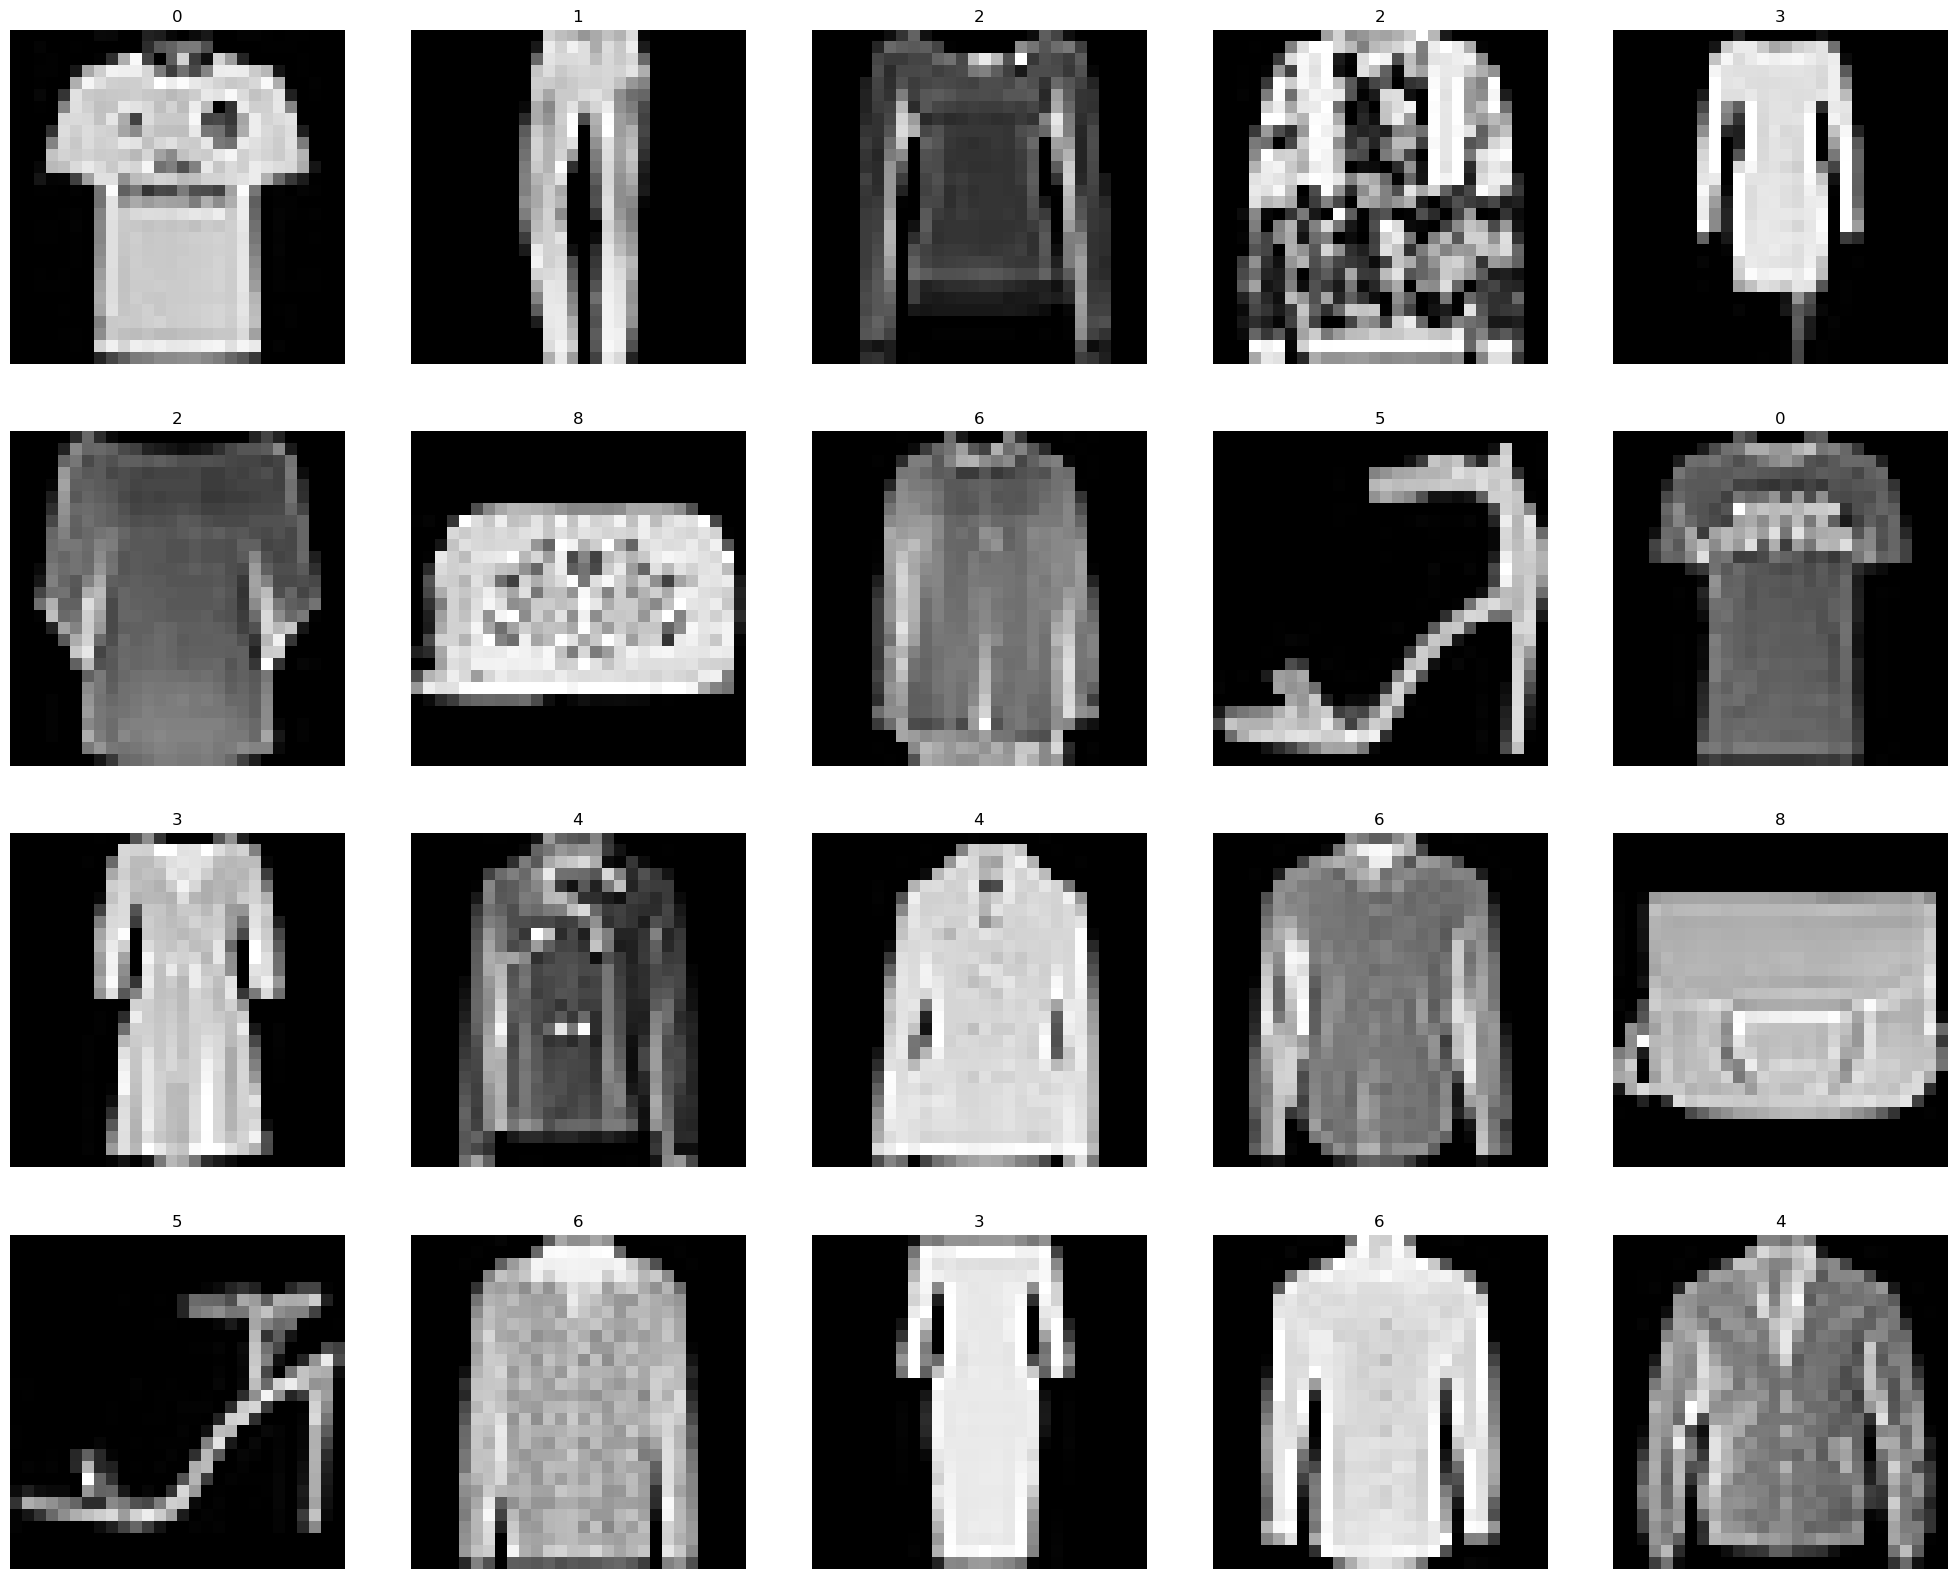

In [14]:
def visualise_images(path_to_fashion_mnist, num_images=20):
    df = pd.read_csv(path_to_fashion_mnist + "fashion_mnist_test.csv")

    fig, ax = plt.subplots(4, 5, figsize=(25, 20))
    ax = ax.ravel()
    for i in range(num_images):
        img = df.iloc[i, 1:].values.reshape(28, 28)
        label = df.iloc[i, 0]
        ax[i].imshow(img, cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(label)
    plt.show()

visualise_images(path_to_fashion_mnist, num_images=20)


Guess for the labels:
0: T Shirt
1: Pant
2: Jacket
3: Dress
4: Coat
5: Footwear
6: Shirt
7: Sandal
8: Bag
9: Boot

In [17]:
def load_data(path_to_fashion_mnist):
    class FashionMNISTDataset(Dataset):
        def __init__(self, csv_file, transform=None):
            self.data = pd.read_csv(csv_file)
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28, 1)
            label = self.data.iloc[idx, 0]
            if self.transform:
                img = self.transform(img)
            return img, label

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = FashionMNISTDataset(path_to_fashion_mnist + "fashion_mnist_train.csv", transform=transform)
    val_dataset = FashionMNISTDataset(path_to_fashion_mnist + "fashion_mnist_val.csv", transform=transform)
    test_dataset = FashionMNISTDataset(path_to_fashion_mnist + "fashion_mnist_test.csv", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

#### `2. CNN AutoEncoder`

In [24]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            # output: 8 x 28 x 28
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            # output: 16 x 14 x 14
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            # output: 32 x 7 x 7
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
            # output: 64 x 4 x 4
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
            # output: 32 x 7 x 7
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            # output: 16 x 14 x 14
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            # output: 8 x 28 x 28
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
            # output: 1 x 28 x 28
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cpu", wandb_log=False, logging=False):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (img, _) in enumerate(train_loader):
            img = img.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (img, _) in enumerate(val_loader):
                img = img.to(device)
                output = model(img)
                loss = criterion(output, img)
                val_loss += loss.item()
            val_loss /= len(val_loader)

        if logging:
            print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if wandb_log:
            wandb.log({"Train Loss": train_loss, "Val Loss": val_loss})

        

In [26]:
def train_driver(
        num_epochs=10,
        optimizer_type="adam",
        device="cpu",
        lr=0.001,
        wandb_log=False,
        logging=True):
    
    model = CNNAutoEncoder()
    model.to(device)
    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    train_loader, val_loader, test_loader = load_data(path_to_fashion_mnist)
    train(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, wandb_log=wandb_log, logging=logging)

    return model, train_loader, val_loader, test_loader

In [33]:
def test_model(model, test_loader, criterion, device="cpu"):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, (img, _) in enumerate(test_loader):
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    print(f"Test MSE Loss: {test_loss:.4f}")


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_autoencoder_model, train_loader, val_loader, test_loader = train_driver(num_epochs=10, optimizer_type="adam", device=device, lr=0.001, wandb_log=False, logging=True)

Epoch 1/10 => Train Loss: 0.0227, Val Loss: 0.0079
Epoch 2/10 => Train Loss: 0.0066, Val Loss: 0.0060
Epoch 3/10 => Train Loss: 0.0053, Val Loss: 0.0050
Epoch 4/10 => Train Loss: 0.0045, Val Loss: 0.0043
Epoch 5/10 => Train Loss: 0.0038, Val Loss: 0.0035
Epoch 6/10 => Train Loss: 0.0032, Val Loss: 0.0034
Epoch 7/10 => Train Loss: 0.0028, Val Loss: 0.0027
Epoch 8/10 => Train Loss: 0.0025, Val Loss: 0.0024
Epoch 9/10 => Train Loss: 0.0023, Val Loss: 0.0025
Epoch 10/10 => Train Loss: 0.0021, Val Loss: 0.0021


In [34]:
test_model(cnn_autoencoder_model, test_loader, nn.MSELoss(), device=device)

Test MSE Loss: 0.0020


#### `3. Plots and Visualizations`

In [48]:
def visualise_reconstruction(model, test_loader, num_images=5, device="cpu"):
    model.eval()
    fig, ax = plt.subplots(2, num_images, figsize=(25, 10))
    ax = ax.ravel()
    with torch.no_grad():
        for i, (img, _) in enumerate(test_loader):
            if i == num_images:
                break
            img = img.to(device)
            output = model(img)
            # print(img.shape, output.shape)
            # img and output size is batch x 1 x 28 x 28
            ax[i].imshow(img[0][0], cmap="gray")
            ax[i].axis("off")
            ax[i].set_title("Original")
            ax[i+num_images].imshow(output[0][0].cpu(), cmap="gray")
            ax[i+num_images].axis("off")
            ax[i+num_images].set_title("Reconstructed")

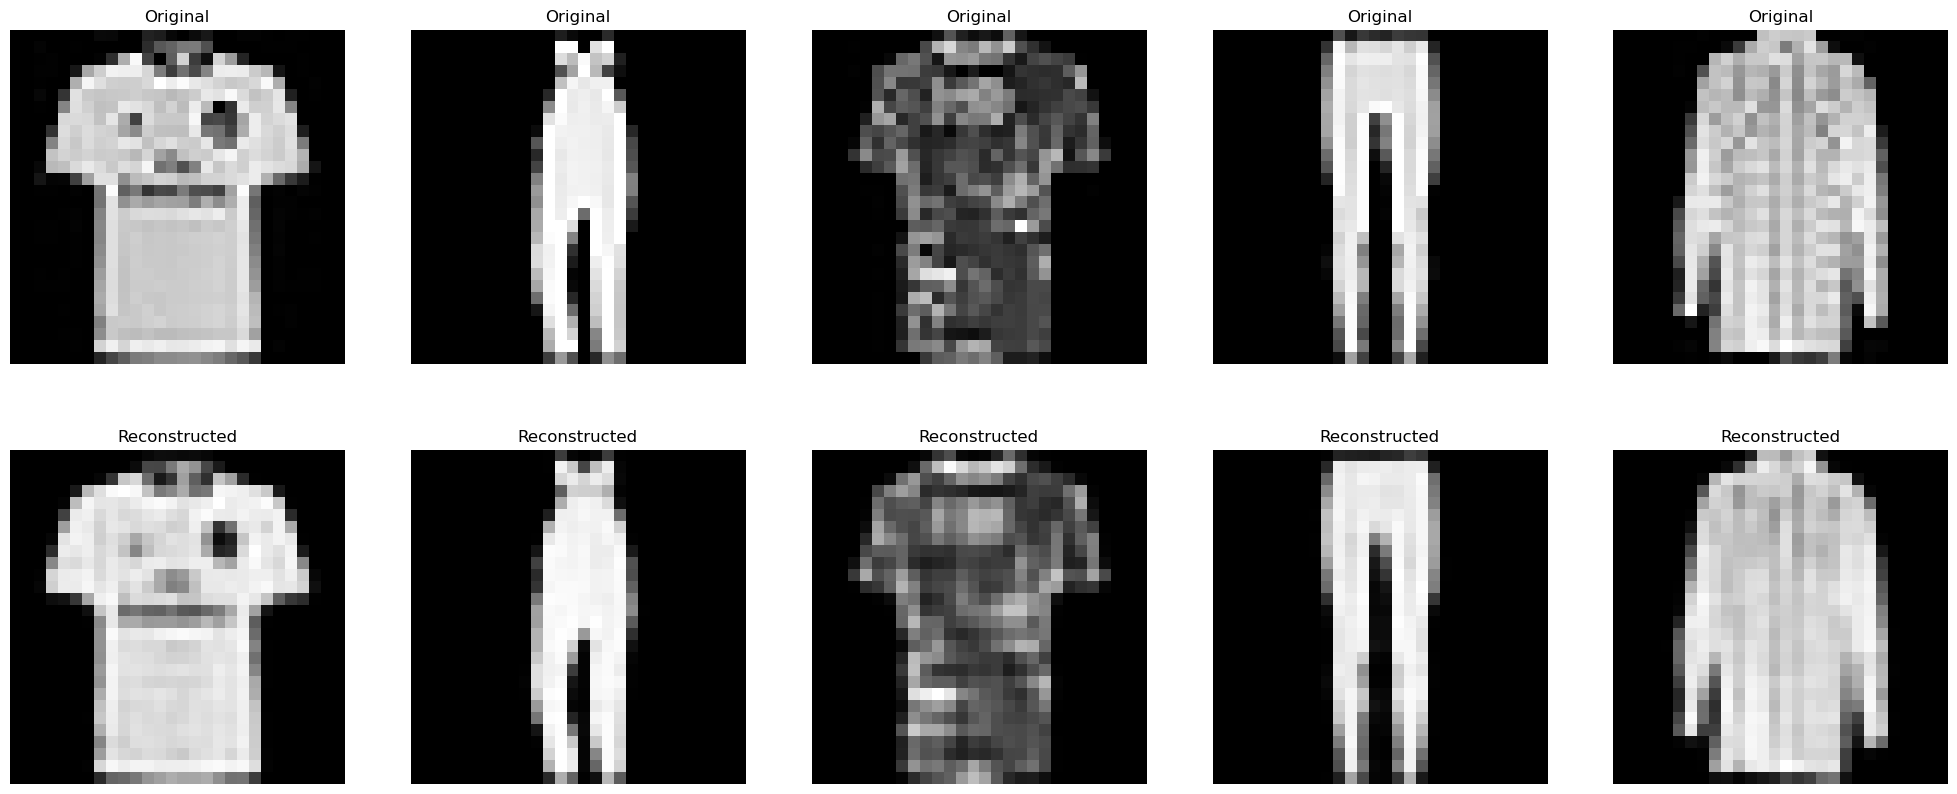

In [49]:
visualise_reconstruction(cnn_autoencoder_model, test_loader, num_images=5, device=device)

In [69]:
def visualise_latent_space(model, test_loader, device="cpu"):
    model.eval()
    latents = []
    labels_list = []
    with torch.no_grad():
        for i, (img, labels) in enumerate(test_loader):
            img = img.to(device)
            latent = model.encode(img)
            latents.append(latent.view(latent.size(0), -1).cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    return latents, labels

latents, labels = visualise_latent_space(cnn_autoencoder_model, test_loader, device=device)

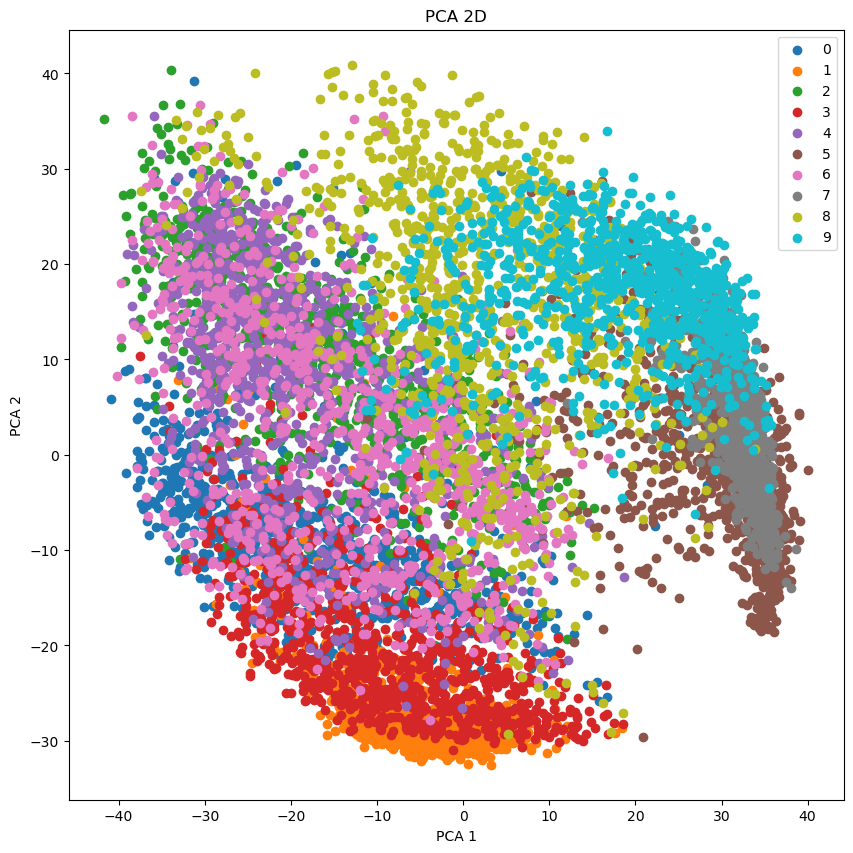

In [80]:
plt.figure(figsize=(10, 10))

pca_2D = PCA(n_components=2)
latents_2D = pca_2D.fit_transform(latents)
for i in range(10):
    plt.scatter(latents_2D[labels == i, 0], latents_2D[labels == i, 1], label=str(i))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.title("PCA 2D")
plt.show()


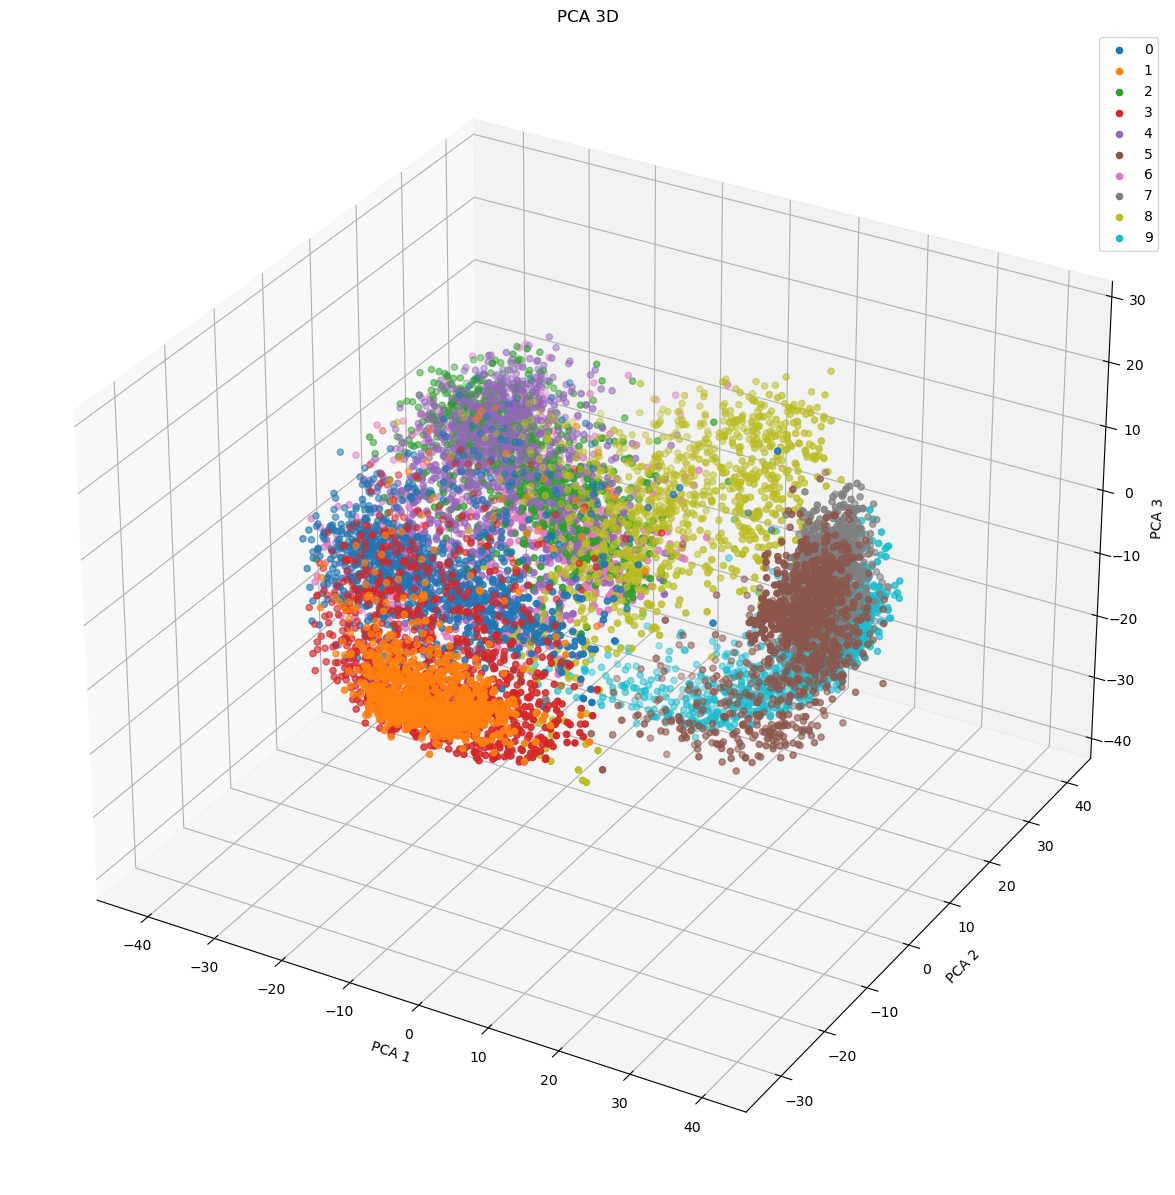

In [78]:
pca_3D = PCA(n_components=3)
latents_3D = pca_3D.fit_transform(latents)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")
for i in range(10):
    ax.scatter(latents_3D[labels == i, 0], latents_3D[labels == i, 1], latents_3D[labels == i, 2], label=str(i))
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.legend()
plt.title("PCA 3D")
plt.show()


It is clear from the above plots that similar images are clustered together. That means the autoencoder is able to learn the features of the images and group them together well.

#### `4. Hyperparameter Tuning`